In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Mtech /Dissertation/data_output/raw_data_converted_without_fp.csv')
mask = data['status'] == 'completed'
data['label'] = mask.map({True: 1, False: 0})
data= data.fillna("")
data['combine_data'] = data['why_stop_updated'] + "  " + data["diseases_updated"] + "  " + data["drugs_updated"] + data["criteria_updated"]

In [ ]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(data['combine_data'])  # Replace 'diseases' with the appropriate column name
X_text = tokenizer.texts_to_sequences(data['combine_data'])  # Convert text to sequences
X_text = pad_sequences(X_text, maxlen=1000)  # Pad sequences if needed
X_train, X_test, y_train, y_test = train_test_split(X_text, data['label'], test_size=0.2, random_state=42, stratify = data['label'])


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11656, 1000), (2915, 1000), (11656,), (2915,))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         16079100  
                                                                 
 lstm (LSTM)                 (None, 1000, 128)         219648    
                                                                 
 lstm_1 (LSTM)               (None, 1000, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 1000, 128)         131584    
                                                                 
 dense (Dense)               (None, 1000, 64)          8256      
                                                                 
 dropout (Dropout)           (None, 1000, 64)          0         
                                                                 
 dense_1 (Dense)             (None, 1000, 1)           6

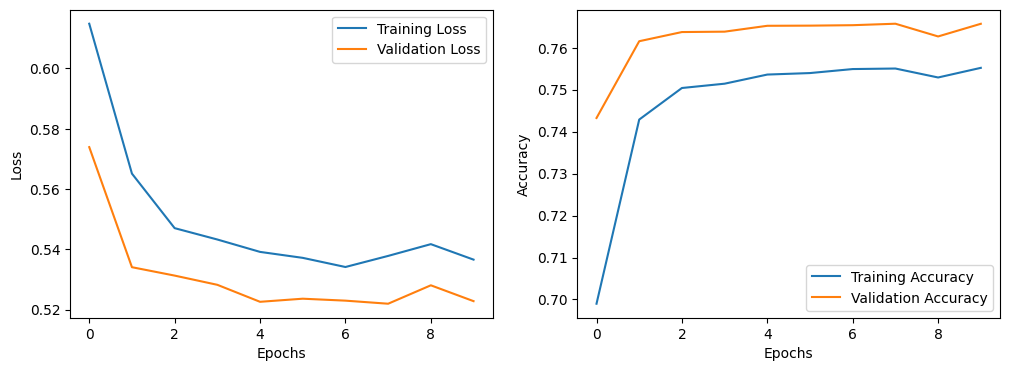

In [ ]:

# Define the hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
max_sequence_length = X_train.shape[1]  # Set based on your data

# Create the model
model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Add multiple LSTM layers for sequence modeling
model.add(LSTM(units=128, return_sequences=True))
model.add(LSTM(units=128, return_sequences=True))
model.add(LSTM(units=128, return_sequences=True))

# Add dense layers
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))

# Output layer for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary to review architecture
model.summary()

# Train the model and keep the history
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Plot training history (loss and accuracy)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

92/92 [==============================] - 45s 483ms/step - loss: 0.5485 - accuracy: 0.7535
Test Loss: 0.5484908819198608, Test Accuracy: 0.7535484433174133


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 100)          5359700   
                                                                 
 bidirectional_3 (Bidirecti  (None, 500, 256)          234496    
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 500, 256)          394240    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 500, 256)          394240    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 500, 32)           8224      
                                                      

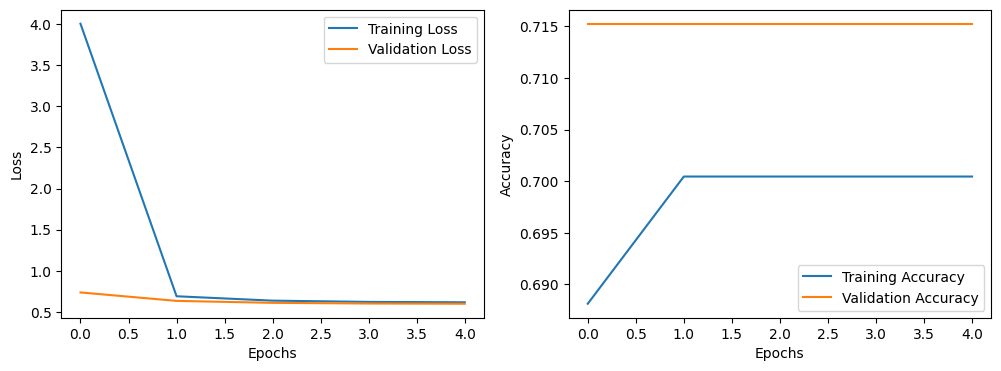

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define the hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
max_sequence_length = 500  # Set based on your data

# Create the model
model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Add multiple Bidirectional LSTM layers for sequence modeling
model.add(Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.01))))

# Add dense layers with progressively decreasing units and regularization
model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(units=16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(units=8, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Output layer for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()
# Train the model and keep the history
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Plot training history (loss and accuracy)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

92/92 [==============================] - 100s 1s/step - loss: 0.6092 - accuracy: 0.7033
Test Loss: 0.609247088432312, Test Accuracy: 0.7032589912414551
